In [1]:
%matplotlib inline
import glob
from sklearn.naive_bayes import MultinomialNB
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import map_tag
from sklearn.metrics import classification_report
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans 
from sklearn.feature_selection import mutual_info_classif, SelectKBest
stop_words = set(stopwords.words('english'))
from matplotlib.lines import Line2D

In [2]:
# just to see the non null objects.
icse = pd.read_csv("icse.txt", delimiter='\t')
icse.columns = ['id','title','title_small','year','date','unnamed','conference','conference_short','reference1','reference2','reference3']
icse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10085 entries, 0 to 10084
Data columns (total 11 columns):
id                  10085 non-null object
title               10085 non-null object
title_small         10085 non-null object
year                10085 non-null int64
date                9673 non-null object
unnamed             6636 non-null object
conference          10085 non-null object
conference_short    10085 non-null object
reference1          15 non-null object
reference2          10085 non-null object
reference3          10085 non-null int64
dtypes: int64(2), object(9)
memory usage: 866.8+ KB


In [3]:
sigmod = pd.read_csv("sigmod.txt", delimiter='\t')
sigmod.columns = ['id','title','title_small','year','date','unnamed','conference','conference_short','reference1','reference2','reference3']
sigmod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195 entries, 0 to 4194
Data columns (total 11 columns):
id                  4195 non-null object
title               4195 non-null object
title_small         4195 non-null object
year                4195 non-null int64
date                3811 non-null object
unnamed             2408 non-null object
conference          4195 non-null object
conference_short    4195 non-null object
reference1          1420 non-null object
reference2          4195 non-null object
reference3          4195 non-null int64
dtypes: int64(2), object(9)
memory usage: 360.6+ KB


In [4]:
vldb = pd.read_csv("vldb.txt", delimiter='\t')
vldb.columns = ['id','title','title_small','year','date','unnamed','conference','conference_short','reference1','reference2','reference3']
vldb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 11 columns):
id                  4323 non-null object
title               4323 non-null object
title_small         4323 non-null object
year                4323 non-null int64
date                3969 non-null object
unnamed             1224 non-null object
conference          4323 non-null object
conference_short    4323 non-null object
reference1          4007 non-null object
reference2          4323 non-null object
reference3          4323 non-null int64
dtypes: int64(2), object(9)
memory usage: 371.6+ KB


In [76]:
vldb.head()

,id,title,title_small,year,date,unnamed,conference,conference_short,reference1,reference2,reference3
0,7E3FCD58,Structural trend analysis for online social ne...,structural trend analysis for online social ne...,2011,2011/07/01,10.14778/2021017.2021022,very large data bases,vldb,0215FD76,4390334E,18864
1,07803372,SQL/AA: Executing SQL on an Asymmetric Archite...,sql aa executing sql on an asymmetric architec...,2014,2014/09,NaN,very large data bases,vldb,0215FD76,4390334E,19476
2,7993CFAF,SCOUT: prefetching for latent structure follow...,scout prefetching for latent structure followi...,2012,2012/07/01,NaN,very large data bases,vldb,0215FD76,4390334E,19452
3,61F6E244,Probabilistic nearest neighbor queries on unce...,probabilistic nearest neighbor queries on unce...,2013,2013/05/15,NaN,very large data bases,vldb,0215FD76,4390334E,19158
4,7DE9428F,"SEDA: a system for search, exploration, discov...",seda a system for search exploration discovery...,2008,2008/08/01,10.14778/1454159.1454185,very large data bases,vldb,0215FD76,4390334E,19264


In [5]:
allFiles = ["vldb.txt","sigmod.txt"]
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,delimiter='\t')
    df.columns = ['id','title','title_small','year','date','unnamed','conference','conference_short','reference1','reference2','reference3']
    list_.append(df)
frame = pd.concat(list_)

data_x = frame[['title']].as_matrix()
print(data_x)
data_y = frame[['conference_short']].as_matrix()
print(data_y)

[['Structural trend analysis for online social networks']
 ['SQL/AA: Executing SQL on an Asymmetric Architecture']
 ['SCOUT: prefetching for latent structure following queries']
 ...
 ['Versions and workspaces in Microsoft repository']
 ['Anatomy of a real E-commerce system']
 ['Efficient optimistic concurrency control using loosely synchronized clocks']]
[['vldb']
 ['vldb']
 ['vldb']
 ...
 ['sigmod']
 ['sigmod']
 ['sigmod']]


C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [6]:
print((frame))

            id                                              title  \
0     7E3FCD58  Structural trend analysis for online social ne...   
1     07803372  SQL/AA: Executing SQL on an Asymmetric Archite...   
2     7993CFAF  SCOUT: prefetching for latent structure follow...   
3     61F6E244  Probabilistic nearest neighbor queries on unce...   
4     7DE9428F  SEDA: a system for search, exploration, discov...   
...        ...                                                ...   
4190  7E296B6D  Handling very large databases with informix ex...   
4191  7DB4B9E7  Towards an effective calculus for object query...   
4192  777253E2    Versions and workspaces in Microsoft repository   
4193  755361A0                Anatomy of a real E-commerce system   
4194  7DC4738A  Efficient optimistic concurrency control using...   

                                            title_small  year        date  \
0     structural trend analysis for online social ne...  2011  2011/07/01   
1     sql aa exec

In [7]:
tfidf__max_df: (2000,3000,5000)
tfidf__ngram_range: ((1, 1), (1, 2), (1, 3))

In [8]:
data_x = frame[['title']].as_matrix()
print(data_x)
data_y = frame[['conference_short']].as_matrix()
print(data_y)

[['Structural trend analysis for online social networks']
 ['SQL/AA: Executing SQL on an Asymmetric Architecture']
 ['SCOUT: prefetching for latent structure following queries']
 ...
 ['Versions and workspaces in Microsoft repository']
 ['Anatomy of a real E-commerce system']
 ['Efficient optimistic concurrency control using loosely synchronized clocks']]
[['vldb']
 ['vldb']
 ['vldb']
 ...
 ['sigmod']
 ['sigmod']
 ['sigmod']]


C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
# split the data
stratified_split = StratifiedShuffleSplit(n_splits=2, test_size=0.3)
for train_index, test_index in stratified_split.split(data_x, data_y):
    x_train, x_test = data_x[train_index], data_x[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]
train_x = [x[0].strip() for x in x_train.tolist()]
test_x = [x[0].strip() for x in x_test.tolist()]

In [67]:
svc_pipe = Pipeline(steps=[('tf',TfidfVectorizer()),('svc',SVC())])
svc_grid = {
    'tf__max_features' :[2000,3000,5000],
    'tf__stop_words' :['english'],
    'tf__ngram_range':[(1,1),(1,2)],
    'tf__use_idf' :[True,False],
    'svc__C' :[3,5],
    'svc__tol' :[1e-3,1e-5],
    'svc__class_weight':[{0:0.05,1:0.8},{0:0.07,1:1}]
}
    
svc_gs = GridSearchCV(svc_pipe, svc_grid, n_jobs=-1)
svc_gs.fit(train_x, train_y)
# print("Best svc params:\n",svc_gs.best_params_)
svc_pred = svc_gs.predict(test_x)
svc_conf = confusion_matrix(test_y,svc_pred)
svc_heatmap = sns.heatmap(svc_conf, cmap="YlGnBu", annot=True, square=True, fmt=".0f").get_figure()
svc_heatmap.savefig('svc_heatmap.png',dpi=400)

print(classification_report(test_y,svc_pred))

C:\Users\vinay\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ValueError: Class label 0 not present.

Naive bayes

In [19]:
pipeline_NB = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
parameters_NB = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}

SVM

In [61]:
pipeline_SVM = Pipeline(
    [
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LinearSVC()))])
parameters_SVM = {
    'tfidf__max_df': (2000,3000,5000),
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "clf__estimator__C": [3, 5],
    "clf__estimator__tol" :[1e-3,1e-5],
    "clf__estimator__class_weight": ['balanced', None],
}

logistic regression

In [59]:
pipeline_logistic = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LogisticRegression(solver='sag'))])
parameters_logistic = {
    'tfidf__max_df': (2000),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__C": [3, 5],
    '__tol' :[1e-3,1e-5],
    "clf__class_weight": [{0:0.05,1:0.8},{0:0.07,1:1}],
}

In [68]:
import pprint
grid_search_tune = GridSearchCV(
    pipeline_SVM, parameters_SVM, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_x, y_train)


print("Best parameters set fot SVM are:")
print(grid_search_tune.best_estimator_.steps)

# measuring performance on test set
print("Applying best classifier on test data:")
best_clf = grid_search_tune.best_estimator_
predictions = best_clf.predict(test_x)

print(classification_report(y_test, predictions))

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   19.8s finished


Best parameters set fot SVM are:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.25, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LinearSVC(C=3, class_weight=None

In [31]:
grid_search_tune = GridSearchCV(
    pipeline_NB
    , parameters_NB, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_x, y_train)


print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

# measuring performance on test set
print("Applying best classifier on test data:")
best_clf = grid_search_tune.best_estimator_
predictions = best_clf.predict(test_x)

print(classification_report(y_test, predictions))

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed:    8.6s finished


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.25, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)), ('clf', OneVsRestClassifier(estimator=MultinomialNB(alpha=0.01, class_prior=None,


In [40]:
grid_search_tune = GridSearchCV(
    pipeline_logistic
    , parameters_logistic, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_x, y_train)


print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

# measuring performance on test set
print("Applying best classifier on test data:")
best_clf = grid_search_tune.best_estimator_
predictions = best_clf.predict(test_x)

print(classification_report(y_test, predictions))

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed:   27.0s finished


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.25, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None,
 

K means clustering

[[ 0.00226983 -0.03085186]
 [-0.01076381 -0.03130496]
 [-0.01665605 -0.02319936]
 ...
 [-0.02040651 -0.02391644]
 [-0.01971976 -0.02255648]
 [-0.06503738  0.10109133]]


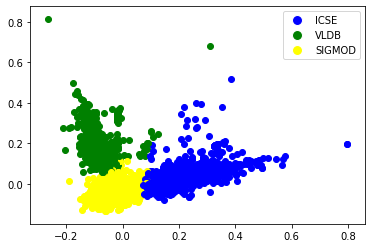

In [18]:
num_clusters = 3
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: 'blue', 1: 'green', 2: 'yellow'}
pca_num_components = 2

# texts_list = some array of strings for which TF-IDF is being computed
# calculate tf-idf of texts
# create k-means model with custom config
x_train_corrected = [" ".join(x) for x in x_train]

vectorizer=TfidfVectorizer(min_df=1,max_df=0.5,stop_words='english', decode_error='ignore')
tf_idf_matrix = vectorizer.fit_transform(x_train_corrected)
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)
X = tf_idf_matrix.todense()
labels = clustering_model.fit_predict(tf_idf_matrix)

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
print(reduced_data)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
# verify labels
legend_elements = [Line2D([0], [0], marker='o', color='w', label='ICSE',
                          markerfacecolor=labels_color_map[0], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='VLDB',
                          markerfacecolor=labels_color_map[1], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='SIGMOD',
                          markerfacecolor=labels_color_map[2], markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [5962, 20]

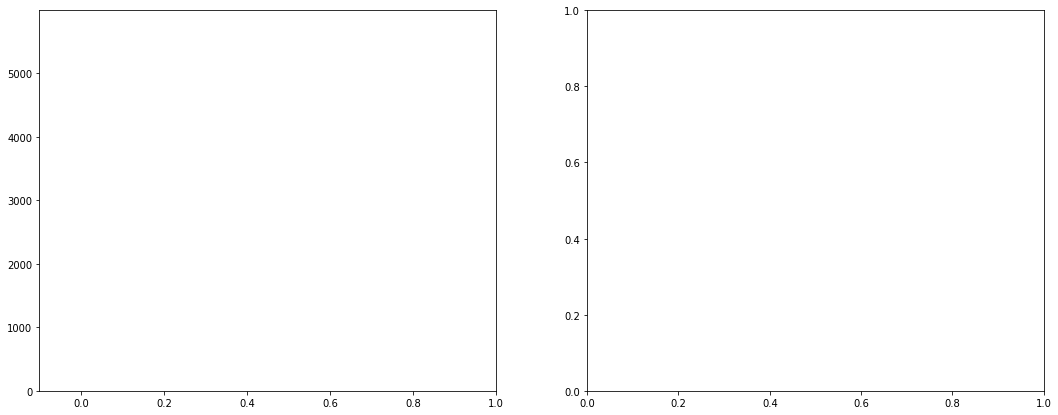

In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Text(0.5, 0, '$\\chi^2$ for ICSE and VLDB')

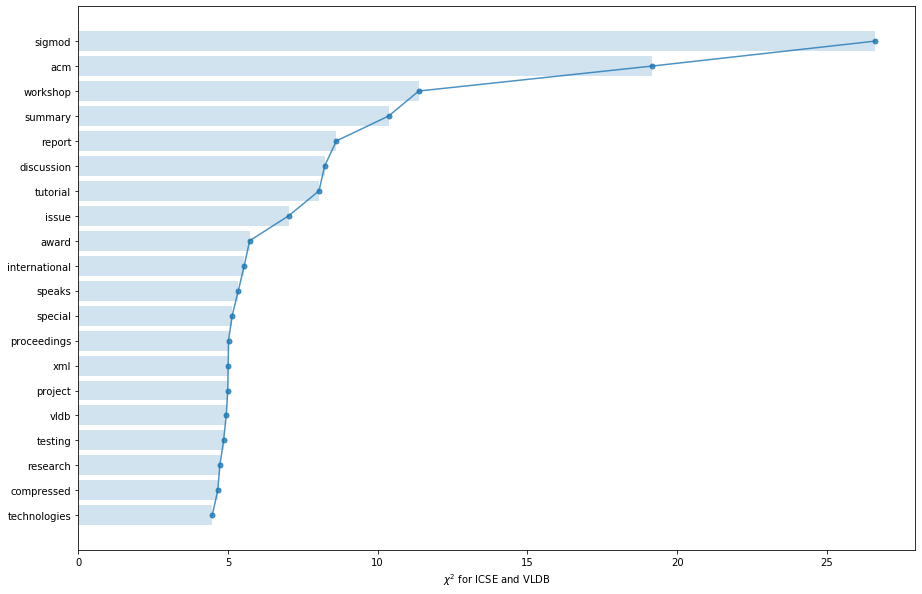

In [70]:
x_train_corrected = [" ".join(x) for x in data_x]
vectorizer=TfidfVectorizer(min_df=1,max_df=0.5,stop_words='english', decode_error='ignore')
tf_idf_matrix = vectorizer.fit_transform(x_train_corrected)
chi2score = chi2(tf_idf_matrix, data_y)[0]

plt.figure(figsize=(15,10))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$ for ICSE and VLDB')

In [74]:
stratified_split = StratifiedShuffleSplit(n_splits=2, test_size=0.3)
for train_index, test_index in stratified_split.split(chi2score, topchi2):
    x_train, x_test = chi2score[train_index], chi2score[test_index]
    y_train, y_test = topchi2[train_index], topchi2[test_index]
train_x = [x[0].strip() for x in x_train.tolist()]
test_x = [x[0].strip() for x in x_test.tolist()]

ValueError: Found input variables with inconsistent numbers of samples: [6843, 2]

In [19]:
km_model = KMeans(n_clusters=3, max_iter=10, n_init=2, random_state=0)

# K-means (transform dimensions from number of features in input matrix to n_clusters)
km_model.fit(reduced_data)
df_centers = pd.DataFrame(km_model.cluster_centers_, columns=['x', 'y'])

print("df_centers:")
print(df_centers)

df_centers:
          x         y
0 -0.025526 -0.034075
1  0.192310  0.021851
2 -0.075246  0.166221


In [20]:
print(len(y_train))

12464


In [19]:
kmeans = KMeans(n_clusters=3, max_iter=10, n_init=2, random_state=0)  
kmeans.fit(reduced_data) 

#print(kmeans.cluster_centers_)
#print(kmeans.labels_)
#print(y)
z=kmeans.labels_ 
#g=sns.lmplot(x="x1",y="x2",data=df,fit_reg=False,hue="Class")
#sns.lmplot(x="x1",y="x2",data=df,fit_reg=False,hue=z,markers=['o','v'])
#plt.scatter(X[:,0],X[:,1],c=y, cmap='rainbow')
#plt.scatter(X[:,0],X[:,1],marker='v')
for a,b,c,d in zip(reduced_data[:,0],reduced_data[:,1],z,y_train):
    if c==0:
        if d==0:
            plt.scatter(a,b,c='y',marker='+')
        elif d==1:
            plt.scatter(a,b,c='g',marker='+')  
        elif d==2:
            plt.scatter(a,b,c='r',marker='+') 
    elif c==1:
        if d==0:
            plt.scatter(a,b,c='y',marker='o')
        elif d==1:
            plt.scatter(a,b,c='g',marker='o')  
        elif d==2:
            plt.scatter(a,b,c='r',marker='o') 
    elif c==2:
        if d==0:
            plt.scatter(a,b,c='y',marker='v')
        elif d==1:
            plt.scatter(a,b,c='g',marker='v')  
        elif d==2:
            plt.scatter(a,b,c='r',marker='v')     
plt.show()

chi squared for ICSE and VLDB

In [20]:
allFiles = ["icse.txt","vldb.txt"]
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,delimiter='\t')
    df.columns = ['id','title','title_small','year','date','unnamed','conference','conference_short','reference1','reference2','reference3']
    list_.append(df)
frame = pd.concat(list_)

data_x = frame[['title']].as_matrix()
print(data_x)
data_y = frame[['conference_short']].as_matrix()
print(data_y)

[['Co-Operative Method Development revisited']
 ['An integrated bug processing framework']
 ['Guest Editorial: Introduction to the Special Section']
 ...
 ['ACM transactions on database systems: aim and scope']
 ['The entity-relationship model—toward a unified view of data']
 ['Data Integration Using Web Services']]
[['icse']
 ['icse']
 ['icse']
 ...
 ['vldb']
 ['vldb']
 ['vldb']]


C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


[['Co-Operative Method Development revisited']
 ['An integrated bug processing framework']
 ['Guest Editorial: Introduction to the Special Section']
 ...
 ['Versions and workspaces in Microsoft repository']
 ['Anatomy of a real E-commerce system']
 ['Efficient optimistic concurrency control using loosely synchronized clocks']]
[['icse']
 ['icse']
 ['icse']
 ...
 ['sigmod']
 ['sigmod']
 ['sigmod']]


Text(0.5, 0, '$\\chi^2$ for ICSE and SIGMOD')

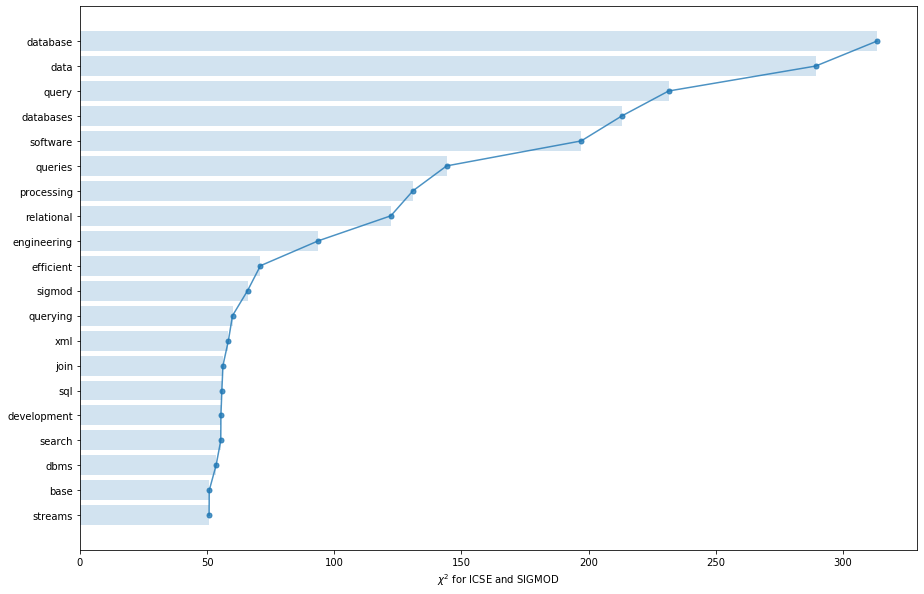

In [27]:
allFiles = ["icse.txt","sigmod.txt"]
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,delimiter='\t')
    df.columns = ['id','title','title_small','year','date','unnamed','conference','conference_short','reference1','reference2','reference3']
    list_.append(df)
frame = pd.concat(list_)

data_x = frame[['title']].as_matrix()
print(data_x)
data_y = frame[['conference_short']].as_matrix()
print(data_y)

x_train_corrected = [" ".join(x) for x in data_x]
vectorizer=TfidfVectorizer(min_df=1,max_df=0.5,stop_words='english', decode_error='ignore')
tf_idf_matrix = vectorizer.fit_transform(x_train_corrected)
chi2score = chi2(tf_idf_matrix, data_y)[0]

plt.figure(figsize=(15,10))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$ for ICSE and SIGMOD')

In [75]:

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='newton-cg', max_iter=1000)
model.fit(tf_idf_matrix.toarray(), data_y)

y_pred = model.predict(x_test)

C:\Users\vinay\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


NameError: name 'x_test_t' is not defined

C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


[['Structural trend analysis for online social networks']
 ['SQL/AA: Executing SQL on an Asymmetric Architecture']
 ['SCOUT: prefetching for latent structure following queries']
 ...
 ['Versions and workspaces in Microsoft repository']
 ['Anatomy of a real E-commerce system']
 ['Efficient optimistic concurrency control using loosely synchronized clocks']]
[['vldb']
 ['vldb']
 ['vldb']
 ...
 ['sigmod']
 ['sigmod']
 ['sigmod']]


Text(0.5, 0, '$\\chi^2$ for VLDB and SIGMOD')

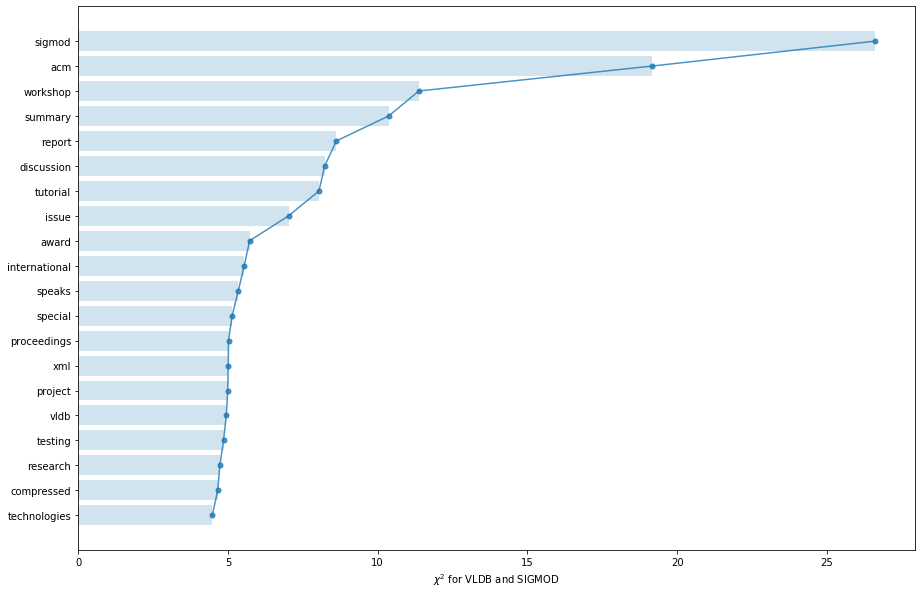

In [28]:
allFiles = ["vldb.txt","sigmod.txt"]
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,delimiter='\t')
    df.columns = ['id','title','title_small','year','date','unnamed','conference','conference_short','reference1','reference2','reference3']
    list_.append(df)
frame = pd.concat(list_)

data_x = frame[['title']].as_matrix()
print(data_x)
data_y = frame[['conference_short']].as_matrix()
print(data_y)

x_train_corrected = [" ".join(x) for x in data_x]
vectorizer=TfidfVectorizer(min_df=1,max_df=0.5,stop_words='english', decode_error='ignore')
tf_idf_matrix = vectorizer.fit_transform(x_train_corrected)
chi2score = chi2(tf_idf_matrix, data_y)[0]

plt.figure(figsize=(15,10))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$ for VLDB and SIGMOD')

In [60]:
allFiles = ["vldb.txt","sigmod.txt"]
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,delimiter='\t')
    df.columns = ['id','title','title_small','year','date','unnamed','conference','conference_short','reference1','reference2','reference3']
    list_.append(df)
frame = pd.concat(list_)

data_x = frame[['title']].as_matrix()
print(data_x)
data_y = frame[['conference_short']].as_matrix()
print(data_y)

x_train_corrected = [" ".join(x) for x in data_x]
vectorizer = TfidfVectorizer(min_df=1,max_df=0.5,stop_words='english', decode_error='ignore')
tf_idf_matrix = vectorizer.fit_transform(x_train_corrected)

# chi2score = chi2(tf_idf_matrix, data_y)[0]
X_new = FastICA(n_components = 20).fit_transform(tf_idf_matrix.toarray(),data_y)

# plt.figure(figsize=(15,10))

C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vinay\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


[['Structural trend analysis for online social networks']
 ['SQL/AA: Executing SQL on an Asymmetric Architecture']
 ['SCOUT: prefetching for latent structure following queries']
 ...
 ['Versions and workspaces in Microsoft repository']
 ['Anatomy of a real E-commerce system']
 ['Efficient optimistic concurrency control using loosely synchronized clocks']]
[['vldb']
 ['vldb']
 ['vldb']
 ...
 ['sigmod']
 ['sigmod']
 ['sigmod']]


Text(0.5, 0, 'FastICA for VLDB and SIGMOD')

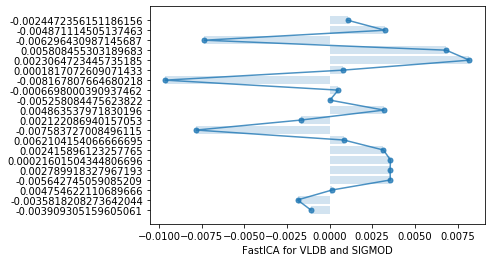

In [62]:
x = range(len(X_new[1]))
labels = X_new[0]
plt.barh(x,X_new[1], align='center', alpha=0.2)
plt.plot(X_new[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('FastICA for VLDB and SIGMOD')

In [66]:
from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(tf_idf_matrix.toarray(), data_y)
f_test /= np.max(f_test)

mi = mutual_info_regression(tf_idf_matrix, data_y)
mi /= np.max(mi)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
plt.show()

C:\Users\vinay\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

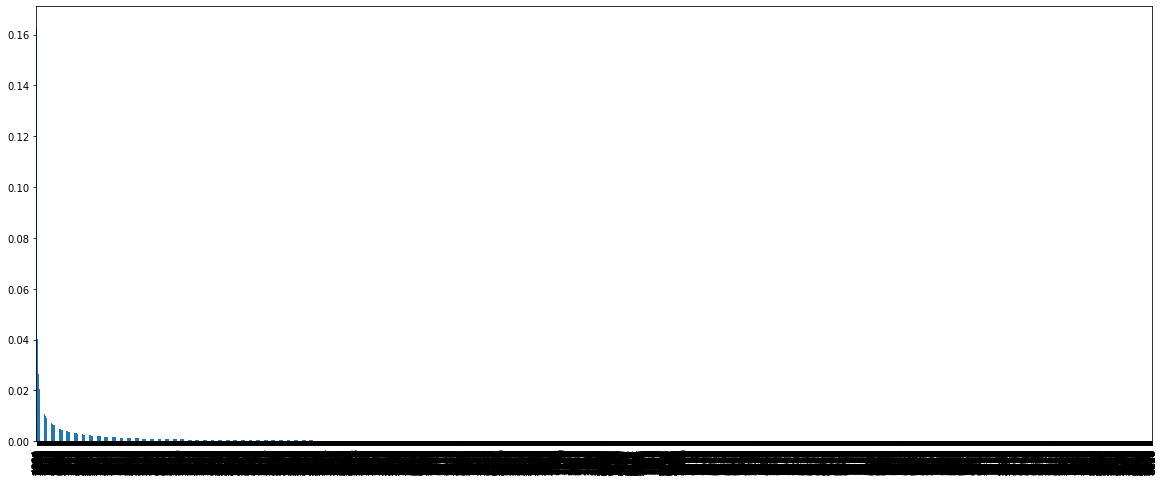

In [64]:
mi_series = pd.Series(mutual_info)
mi_series.sort_values(ascending=False).plot.bar(figsize=(20,8))
# mi_series.sort_values(ascending=False)